## Proyecto Final

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

## Importación de datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import numpy as np
import re

### Descripción de los datos

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

In [2]:
## Importamos los datasets
contract = pd.read_csv('datasets/contract.csv')
personal = pd.read_csv('datasets/personal.csv')
internet = pd.read_csv('datasets/internet.csv')
phone = pd.read_csv('datasets/phone.csv')

## Preprocesamiento de los datos

**Contract**

In [3]:
contract.info()
print("\n" + "="*50 + "\n")
print(contract.describe())
print("\n" + "="*50 + "\n")
print(contract.isnull().sum())
print("\n" + "="*50 + "\n")
print(contract[contract.duplicated].sum())
print("\n" + "="*50 + "\n")
display(contract.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges  

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4104,3345-PBBFH,2019-06-01,No,Month-to-month,Yes,Bank transfer (automatic),49.55,393.45
5650,6047-SUHPR,2016-11-01,No,One year,No,Electronic check,59.80,2343.85
3323,4203-QGNZA,2017-10-01,No,Month-to-month,No,Mailed check,20.25,535.35
3187,7682-AZNDK,2017-04-01,No,Month-to-month,Yes,Electronic check,89.85,3091.75
4310,8908-NMQTX,2014-02-01,No,Two year,Yes,Bank transfer (automatic),65.60,4566.5


Convertimos los nombres de las columnas a snake_case para estandarizar el formato.

In [4]:
# Función para convertir nombres de columnas a snake_case, incluyendo customerID a customer_id
def to_snake_case(col_name):
    # Convertir customerID a customer_id específicamente
    if col_name == 'customerID':
        return 'customer_id'
    # Convertir a snake_case el resto de columnas
    snake_case_col = '_'.join(re.findall(r'[A-Z][a-z0-9]*', col_name)).lower()
    return snake_case_col

# Convertir nombres de columnas a snake_case
snake_case_cols = [to_snake_case(col) for col in contract.columns]
contract.columns = snake_case_cols

# Verificar los nombres de las columnas después de la conversión
print('Nombres de columnas normalizados:')
print(contract.columns)

Nombres de columnas normalizados:
Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')


Convertimos la columna `'begin_date'` a tipo `datetime`

In [5]:
# Convertir la columna 'begin_date' a tipo datetime
contract['begin_date'] = pd.to_datetime(contract['begin_date'], errors='coerce')
# Verificar si la conversión fue exitosa
print(contract['begin_date'].dtype)  # Debería mostrar 'datetime64[ns]'
print(contract['begin_date'].head())  # Ver los primeros valores de la columna

datetime64[ns]
0   2020-01-01
1   2017-04-01
2   2019-10-01
3   2016-05-01
4   2019-09-01
Name: begin_date, dtype: datetime64[ns]


Ademas se obeserva que el tipo de datos de las columna `'total_charges'` es `object` y debería ser `float` al igual que la columna `'monthly_charges'` así que vamos a cambiarla. Pero antes se va a revisar si hay datos que no sean números, como por ejemplo buscar si hay filas que tienen solamente un espacio en blanco

También se van a buscar si hay filas repetidas.

In [6]:
# Buscamos si hay strings en nuestra columna de 'TotalCharges'
print(contract[contract['total_charges'] == ' ']['total_charges'].count())

11


`'total_charges'` debería contener solo valores numéricos (como cantidades facturadas). Encontrar espacios en esta columna significa que esos registros tienen datos faltantes o incorrectos.

In [7]:
# Reemplazar espacios en blanco en 'total_charges' con NaN
contract['total_charges'] = contract['total_charges'].replace(' ', pd.NA)

# Convertir la columna 'total_charges' a tipo float
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')

# Verificar si la conversión fue exitosa
print(contract['total_charges'].dtype)  # Debería mostrar 'float64'
print(contract['total_charges'].head())  # Ver los primeros valores de la columna

float64
0      29.85
1    1889.50
2     108.15
3    1840.75
4     151.65
Name: total_charges, dtype: float64


In [8]:
# Calcular el promedio de 'total_charges', omitiendo los valores nulos
average_total_charges = contract['total_charges'].mean()

# Rellenar los valores nulos con el promedio
contract['total_charges'].fillna(average_total_charges, inplace=True)

# Verificar si hay valores nulos restantes
print(contract['total_charges'].isnull().sum())

0


C:\Users\jpizz\AppData\Local\Temp\ipykernel_4556\1974059395.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  contract['total_charges'].fillna(average_total_charges, inplace=True)


Ahora los valores de la columna `'total_charges'` han sido corregidos: los espacios vacíos han sido reemplazados con `NaN`, y estos valores nulos fueron rellenados utilizando el promedio de la columna. La conversión a tipo `float` también se realizó con éxito, y al verificar nuevamente, se confirmó que no quedan valores nulos en la columna, lo que nos permite continuar con el análisis sin problemas relacionados con datos faltantes o inconsistentes en esta variable.

**Personal**

In [9]:
personal.info()
print("\n" + "="*50 + "\n")
print(personal.describe())
print("\n" + "="*50 + "\n")
print(personal.isnull().sum())
print("\n" + "="*50 + "\n")
print(personal[personal.duplicated].sum())
print("\n" + "="*50 + "\n")
display(personal.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: object




,customerID,gender,SeniorCitizen,Partner,Dependents
3442,0468-YRPXN,Male,0,No,No
2497,5702-SKUOB,Female,0,Yes,No
1140,9553-DLCLU,Female,0,No,Yes
4034,4608-LCIMN,Male,0,Yes,Yes
2590,4526-ZJJTM,Female,1,Yes,No


In [10]:
# Función para convertir nombres de columnas a snake_case, incluyendo customerID a customer_id
def to_snake_case(col_name):
    # Convertir customerID a customer_id específicamente
    if col_name == 'customerID':
        return 'customer_id'
    # Convertir el resto de las columnas a snake_case
    # La expresión regular ahora captura los casos de nombres con letras mayúsculas y minúsculas
    if not col_name:
        return col_name
    snake_case_col = '_'.join(re.findall(r'[a-zA-Z][a-z]*', col_name)).lower()
    return snake_case_col

# Convertir los nombres de las columnas a snake_case
snake_case_cols = [to_snake_case(col) for col in personal.columns]
personal.columns = snake_case_cols

# Verificar los nombres de las columnas después de la conversión
print('Nombres de columnas normalizados:')
print(personal.columns)

Nombres de columnas normalizados:
Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')


Todo está en orden para seguir trabajando

**Internet**

In [11]:
internet.info()
print("\n" + "="*50 + "\n")
print(internet.describe())
print("\n" + "="*50 + "\n")
print(internet.isnull().sum())
print("\n" + "="*50 + "\n")
print(internet[internet.duplicated].sum())
print("\n" + "="*50 + "\n")
display(internet.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     3186-AJIEK     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV StreamingMo

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5415,1450-SKCVI,Fiber optic,No,Yes,No,No,No,No
1230,2245-ADZFJ,DSL,No,Yes,No,Yes,Yes,Yes
4709,1555-DJEQW,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
4139,2927-CVULT,Fiber optic,Yes,Yes,Yes,Yes,No,Yes
2994,6402-EJMWF,DSL,No,No,No,No,No,Yes


In [12]:
# Función para convertir nombres de columnas a snake_case, incluyendo customerID a customer_id
def to_snake_case(col_name):
    # Convertir customerID a customer_id específicamente
    if col_name == 'customerID':
        return 'customer_id'
    # Condición especial para 'streaming_t_v'
    if col_name == 'StreamingTV':
        return 'streaming_tv'
    # Convertir el resto de las columnas a snake_case
    if not col_name:
        return col_name
    # Reemplazar espacios y caracteres no alfanuméricos por guiones bajos
    col_name = re.sub(r'[^a-zA-Z0-9]', '_', col_name)
    # Asegurarse de que los guiones bajos no se dupliquen
    col_name = re.sub(r'_+', '_', col_name)
    # Convertir a minúsculas
    return col_name.lower()

# Convertir los nombres de las columnas a snake_case
snake_case_cols = [to_snake_case(col) for col in internet.columns]
internet.columns = snake_case_cols

# Verificar los nombres de las columnas después de la conversión
print('Nombres de columnas normalizados:')
print(internet.columns)

Nombres de columnas normalizados:
Index(['customer_id', 'internetservice', 'onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'streaming_tv', 'streamingmovies'],
      dtype='object')


Todo está en orden para seguir trabajando

**Phone**

In [13]:
phone.info()
print("\n" + "="*50 + "\n")
print(phone.describe())
print("\n" + "="*50 + "\n")
print(phone.isnull().sum())
print("\n" + "="*50 + "\n")
print(phone[phone.duplicated].sum())
print("\n" + "="*50 + "\n")
display(phone.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


        customerID MultipleLines
count         6361          6361
unique        6361             2
top     3186-AJIEK            No
freq             1          3390


customerID       0
MultipleLines    0
dtype: int64


customerID       0
MultipleLines    0
dtype: object




,customerID,MultipleLines
3309,0512-FLFDW,Yes
5995,1074-WVEVG,No
2425,9481-WHGWY,No
3702,0628-CNQRM,No
2875,9281-OFDMF,Yes


In [14]:
# Función para convertir nombres de columnas a snake_case, incluyendo customerID a customer_id
def to_snake_case(col_name):
    # Convertir customerID a customer_id específicamente
    if col_name == 'customerID':
        return 'customer_id'
    # Convertir a snake_case el resto de columnas
    snake_case_col = '_'.join(re.findall(r'[A-Z][a-z0-9]*', col_name)).lower()
    return snake_case_col

# Convertir nombres de columnas a snake_case
snake_case_cols = [to_snake_case(col) for col in phone.columns]
phone.columns = snake_case_cols

# Verificar los nombres de las columnas después de la conversión
print('Nombres de columnas normalizados:')
print(phone.columns)

Nombres de columnas normalizados:
Index(['customer_id', 'multiple_lines'], dtype='object')


Todo está en orden para seguir trabajando

Antes de seguir voy a unir los datasets ya que se podrá tener una vista integral de cada cliente y hacer un análisis más completo y robusto.

In [15]:
# Unir datasets
merged_df = pd.merge(contract, personal, how='left', on='customer_id')
merged_df = pd.merge(merged_df, internet, how='left', on='customer_id')
merged_df = pd.merge(merged_df, phone, how='left', on='customer_id')

# Verificar la unión
print(merged_df.info())
print(merged_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internetservice    5517 non-null   object        
 13  onlinesecurity     5517 non-null   object        
 14  onlineba

In [16]:
#Verificación de valores nulos
print(merged_df.isnull().sum())

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internetservice      1526
onlinesecurity       1526
onlinebackup         1526
deviceprotection     1526
techsupport          1526
streaming_tv         1526
streamingmovies      1526
multiple_lines        682
dtype: int64


In [17]:
#Limpieza de datos
merged_df.fillna('None', inplace=True)

In [18]:
# Contar duplicados
print(merged_df.duplicated().sum())

0


In [19]:
# Crear una nueva columna 'contract_ended' que muestra si el contrato terminó (True) o no (False)
merged_df['contract_ended'] = merged_df['end_date'] != 'No'

# Verificar los primeros registros para confirmar la creación de la nueva columna
print(merged_df[['customer_id', 'end_date', 'contract_ended']].head())

  customer_id             end_date  contract_ended
0  7590-VHVEG                   No           False
1  5575-GNVDE                   No           False
2  3668-QPYBK  2019-12-01 00:00:00            True
3  7795-CFOCW                   No           False
4  9237-HQITU  2019-11-01 00:00:00            True


C:\Users\jpizz\AppData\Local\Temp\ipykernel_4556\1191079478.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contract_status_counts.index, y=contract_status_counts.values, palette='Set2')


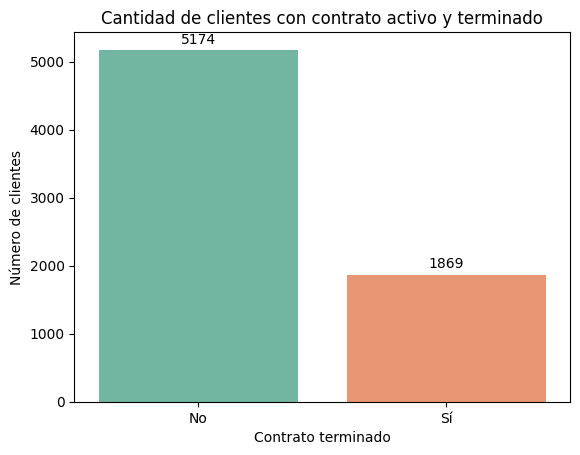

In [20]:
# Contar el número de clientes que han terminado o no su contrato
contract_status_counts = merged_df['contract_ended'].value_counts()

# Crear el gráfico de barras
sns.barplot(x=contract_status_counts.index, y=contract_status_counts.values, palette='Set2')
plt.title('Cantidad de clientes con contrato activo y terminado')
plt.ylabel('Número de clientes')
plt.xlabel('Contrato terminado')
plt.xticks([0, 1], ['No', 'Sí'])  # Etiquetas personalizadas para el eje x

# Añadir los números en las barras
for i, count in enumerate(contract_status_counts.values):
    plt.text(i, count + 50, str(count), ha='center', va='bottom', fontsize=10)  

plt.show()

### ¿Cuál es la distribución de los tipos de contratos entre los clientes?

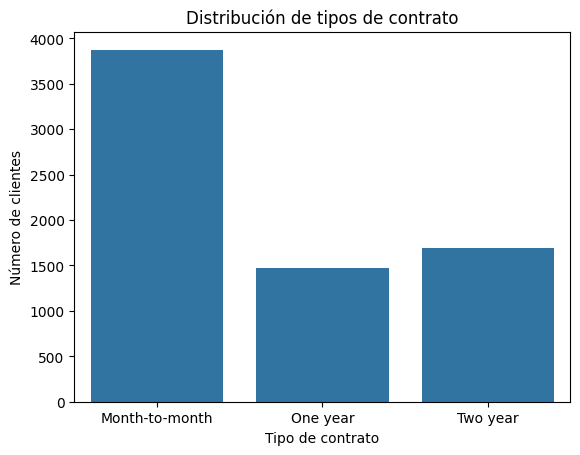

In [21]:
sns.countplot(x='type', data=merged_df)
plt.title('Distribución de tipos de contrato')
plt.xlabel('Tipo de contrato')
plt.ylabel('Número de clientes')
plt.show()

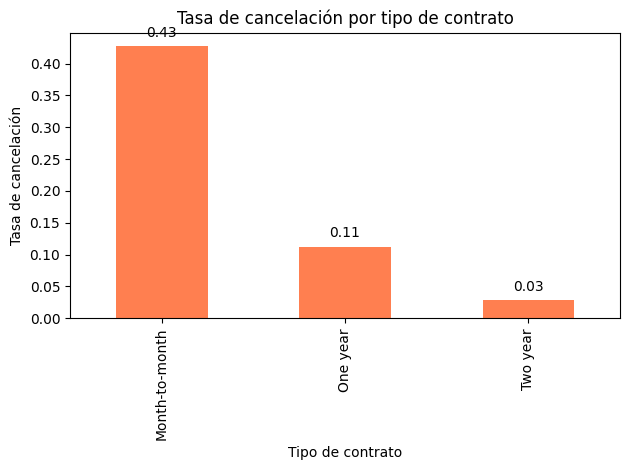

In [22]:
import matplotlib.pyplot as plt

# Calcular la tasa de cancelación por tipo de contrato
churn_rate = merged_df.groupby('type')['end_date'].apply(lambda x: (x != 'No').mean())

# Crear el gráfico de barras
ax = churn_rate.plot(kind='bar', color='coral')

# Título y etiquetas
plt.title('Tasa de cancelación por tipo de contrato')
plt.ylabel('Tasa de cancelación')
plt.xlabel('Tipo de contrato')

# Añadir etiquetas encima de cada barra
for i, value in enumerate(churn_rate):
    ax.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


### ¿Cuál es la relación entre las tarifas mensuales (monthly_charges) y la tasa de cancelación?

C:\Users\jpizz\AppData\Local\Temp\ipykernel_4556\2034213694.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='contract_ended', y='monthly_charges', data=merged_df, palette=colors)


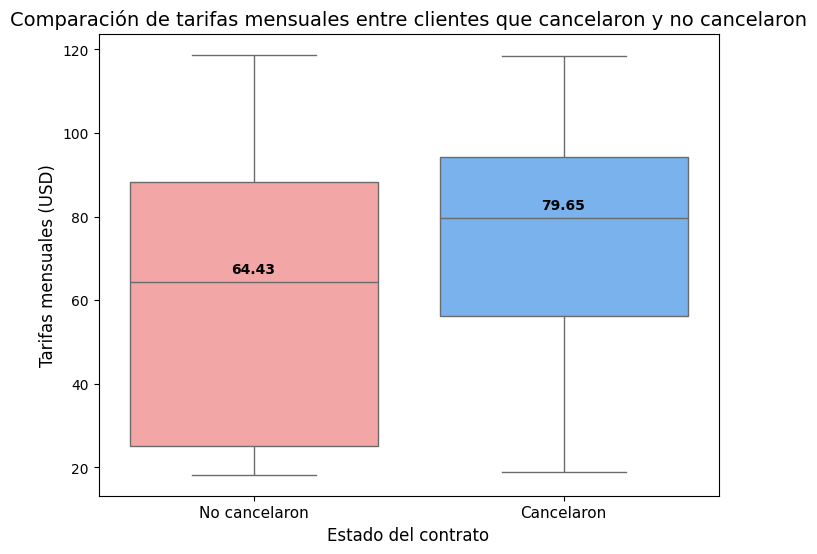

In [23]:
# Definir colores para cancelar y no cancelar
colors = ['#FF9999', '#66B2FF']

# Crear el boxplot con las mejoras
plt.figure(figsize=(8, 6))
sns.boxplot(x='contract_ended', y='monthly_charges', data=merged_df, palette=colors)

# Etiquetas y títulos más claros
plt.title('Comparación de tarifas mensuales entre clientes que cancelaron y no cancelaron', fontsize=14)
plt.xlabel('Estado del contrato', fontsize=12)
plt.ylabel('Tarifas mensuales (USD)', fontsize=12)

# Personalizar etiquetas del eje X para claridad
plt.xticks(ticks=[0, 1], labels=['No cancelaron', 'Cancelaron'], fontsize=11)

# Mostrar la mediana en el gráfico
medians = merged_df.groupby('contract_ended')['monthly_charges'].median()
for index, median in enumerate(medians):
    plt.text(index, median + 2, f'{median:.2f}', horizontalalignment='center', color='black', weight='semibold')

plt.show()



### ¿Cuál es la distribución del tiempo que los clientes han estado con la empresa? ¿Hay alguna diferencia entre los que cancelaron y los que no?

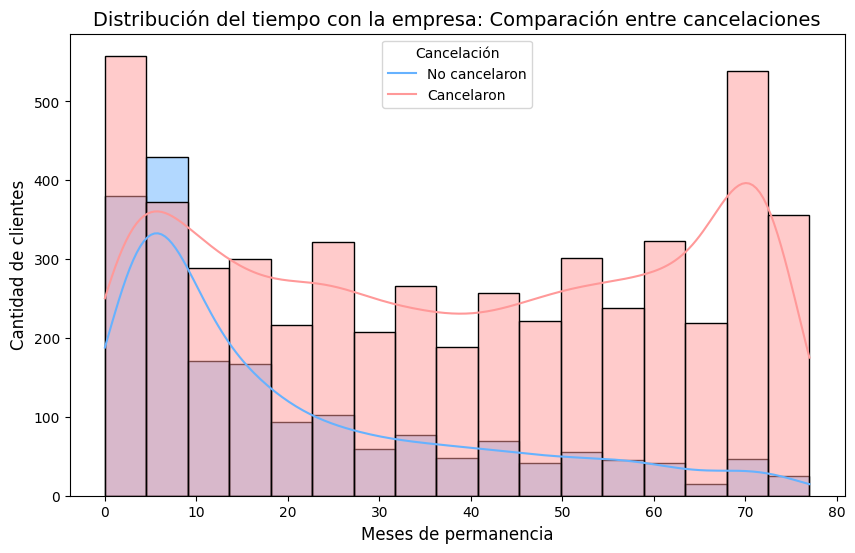

In [24]:
# Crear la columna 'tenure' si no está creada
merged_df['tenure'] = (pd.to_datetime('2020-02-01') - pd.to_datetime(merged_df['begin_date'])).dt.days // 30

# Graficar la distribución de tenure, diferenciando entre clientes que cancelaron y no
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_df, x='tenure', hue='contract_ended', kde=True, palette=['#FF9999', '#66B2FF'])

# Etiquetas y título del gráfico
plt.title('Distribución del tiempo con la empresa: Comparación entre cancelaciones', fontsize=14)
plt.xlabel('Meses de permanencia', fontsize=12)
plt.ylabel('Cantidad de clientes', fontsize=12)
plt.legend(title='Cancelación', labels=['No cancelaron', 'Cancelaron'])
plt.show()

### ¿Ciertos métodos de pago están más relacionados con la cancelación que otros?

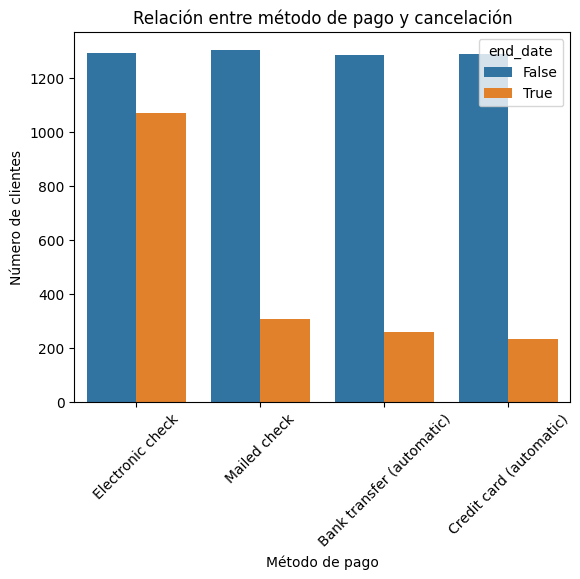

In [25]:
sns.countplot(x='payment_method', hue=merged_df['end_date'] != 'No', data=merged_df)
plt.title('Relación entre método de pago y cancelación')
plt.xlabel('Método de pago')
plt.ylabel('Número de clientes')
plt.xticks(rotation=45)
plt.show()

In [29]:
# Función para convertir 'Yes' y 'No' en 1 y 0, y rellenar 'None' con la moda
def convertir_columnas_yes_no(df):
    # Convertir 'Yes' a 1 y 'No' a 0
    columnas_binarias = df.select_dtypes(include=['object']).columns
    for col in columnas_binarias:
        if df[col].isin(['Yes', 'No']).all():
            df[col] = df[col].map({'Yes': 1, 'No': 0})
    
    # Imputar valores 'None' con la moda de la columna
    for col in df.columns:
        if df[col].isnull().any():
            moda = df[col].mode()[0]  # Obtener la moda
            df[col].fillna(moda, inplace=True)
    
    return df

In [30]:
# 1. Función para OHE y escalado
def procesar_datos(df, target_col):
    # Separar variables categóricas y numéricas
    cat_cols = df.select_dtypes(include=['object']).columns
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns

    # One-Hot Encoding para variables categóricas
    ohe = OneHotEncoder(drop='first', sparse=False)
    df_ohe = pd.DataFrame(ohe.fit_transform(df[cat_cols]), columns=ohe.get_feature_names_out(cat_cols))
    
    # Escalar las variables numéricas
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols)

    # Combinar las columnas transformadas
    df_final = pd.concat([df_scaled, df_ohe, df[target_col].reset_index(drop=True)], axis=1)
    
    return df_final

In [31]:
# 2. Función para división de los datos
def dividir_datos(df, target_col, test_size=0.2, val_size=0.1):
    X = df.drop(columns=target_col)
    y = df[target_col]
    
    # Dividir entre entrenamiento y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    
    # Dividir el set de entrenamiento para obtener un conjunto de validación
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42, stratify=y_train)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [32]:
# 3. Función para sobremuestreo (upsampling)
def upsample(X_train, y_train):
    X = pd.concat([X_train, y_train], axis=1)
    majority_class = X[y_train.name == 0]  # Clase mayoritaria
    minority_class = X[y_train.name == 1]  # Clase minoritaria
    
    # Aumentar la clase minoritaria
    minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)
    
    # Combinar el set original con el sobremuestreado
    upsampled = pd.concat([majority_class, minority_upsampled])
    
    # Dividir nuevamente en X e y
    return upsampled.drop(columns=y_train.name), upsampled[y_train.name]

In [33]:
# 4. Función para submuestreo (downsampling)
def downsample(X_train, y_train):
    X = pd.concat([X_train, y_train], axis=1)
    majority_class = X[y_train.name == 0]  # Clase mayoritaria
    minority_class = X[y_train.name == 1]  # Clase minoritaria
    
    # Reducir la clase mayoritaria
    majority_downsampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=42)
    
    # Combinar el set original con el submuestreado
    downsampled = pd.concat([minority_class, majority_downsampled])
    
    # Dividir nuevamente en X e y
    return downsampled.drop(columns=y_train.name), downsampled[y_train.name]